# TP5 - Graphes de calcul

Implémentation de structure de calculs plus complexes que de simples réseau de neurones profonds.
(Pour plus de détails cf RDFIA/TP_DEEP/Explication_mathématiques)
\begin{equation} f_{\gamma,\theta}(x)=f_\theta \, (x\circ Relu(\gamma)) \end{equation}

In [7]:
 require 'nn'
 require 'gnuplot'
 require 'svm'
 require 'optim'
 require 'nngraph'


-- Test avec mnist (en cours)
local mnist = require 'mnist'

train_file = 'mnist.t7/train_32x32.t7'
test_file = 'mnist.t7/test_32x32.t7'

trainData = torch.load(train_file,'ascii')
testData = torch.load(test_file,'ascii')



trainset = {
    size = 50000,
    data = fullset.data[{{1,50000}}]:double(),
    label = fullset.label[{{1,50000}}]
}


In [14]:
require 'nn'
require 'gnuplot'
require 'svm'
require 'optim'
require 'nngraph'
require 'image'

--Fonction prise dans le guide.lua
function gen_gauss(nbpoints,mu,sigma)
local d = #mu
local X = torch.randn(nbpoints,d)
for i = 1,d do X[{{},i}]=X[{{},i}]*sigma[i]+mu[i] end
return X
end

--Creation de données pour quatres gausiennes
function create_data(parametres,nbpoints)
    local X_final=gen_gauss(nbpoints,parametres[1][1],parametres[1][2])
    local Y_final=torch.ones(nbpoints,1) 
    Y_final=Y_final*parametres[1][3]
    for i=2,4 do
    X_final=torch.cat(X_final,(gen_gauss(nbpoints,parametres[i][1],parametres[i][2])),1)
    Y_final=torch.cat(Y_final,(torch.ones(nbpoints) *parametres[i][3]),1)
    end
    return X_final,Y_final
end


-- Paramètres des quatres gaussiennes {mu,sigma,label {-1,1}}
parametres = {{{1,1},{0.5,0.5},1},
             {{-1,1},{0.5,0.5},-1},
             {{-1,-1},{0.5,0.5},1},
             {{1,-1},{0.5,0.5},-1}}            
   
-- Création de données pour le train & le test 600 points pour le train, 200 pour le test (ratior=75%/25%)   
xtrain,ytrain = create_data(parametres,150)
xtest,ytest=create_data(parametres,50)


In [24]:
--Deux dimensions pour notre jeu de test
N=2
nbIter = 100000
lr = 1e-4
all_losses={}
compt=0
criterion=nn.MSECriterion()

M1=nn.Linear(1,N)
M2=nn.L1Penalty(0.001)
M3=nn.ReLU()
M4=nn.CMulTable()
M5=nn.Linear(N,1)
M6=nn.Tanh()

ones = torch.ones(xtrain:size(1),1)

for i = 1, nbIter do
--Model init Gradient
M1:zeroGradParameters()
M5:zeroGradParameters()
--Forward partie 
O1=M1:forward(ones)
O2=M2:forward(O1)
O3=M3:forward(O2)
O4=M4:forward({xtrain,O3})
O5=M5:forward(O4)
O6=M6:forward(O5)
loss=criterion:forward(O6,ytrain)

--Backward partie
delta=criterion:backward(O6,ytrain)
delta_6=M6:backward(O5,delta)
delta_5=M5:backward(O4,delta_6)
delta_4=M4:backward({xtrain,O3},delta_5)[2]
delta_3=M3:backward(O2,delta_4)
delta_2=M2:backward(O2,delta_3)
delta_1=M1:backward(ones,delta_2)

M1:updateParameters(lr)
M5:updateParameters(lr)
all_losses[i]=loss
end
gnuplot.plot(torch.Tensor(all_losses))

#### Réécriture de la fonction avec nngraph :

\begin{equation} f_{\gamma,\theta}(x)=f_\theta \, (x\circ Relu(\gamma)) \end{equation}

In [23]:
N=2
criterion = nn.MSECriterion()
--Création de noeud d'entrée, utilisation en tant que "parent"
input1=nn.Identity()()
input2=nn.Identity()()
-- Implémentation des modules
M1=nn.Linear(1,N)(input2)
M2=nn.L1Penalty(0.001)(M1)
M3=nn.ReLU()(M2)
M4=nn.CMulTable()({input1,M3})
M5=nn.Linear(N,1)(M4)
M6=nn.Tanh()(M5)
-- Combinaison des différrents inputs
model=nn.gModule({input1,input2},{M6})

nbIter = 100000
lr = 1e-4
all_losses={}
compt=0



matrix_ones = torch.ones(xtrain:size(1),1)

for i = 1, nbIter do
--Initialisation Gradient
model:zeroGradParameters()
-- Forward partie
output=model:forward({xtrain,matrix_ones})
loss=criterion:forward(output,ytrain)

-- Backward partie
delta=criterion:backward(output,ytrain)
model:backward({xtrain,matrix_ones},delta)
model:updateParameters(lr)
all_losses[i]=loss
end
gnuplot.plot(torch.Tensor(all_losses))
--graph.dot(model.fg, 'MLP', 'MLP')



In [17]:
itorch.image('MLP.svg',{nrow=22})

3d45818a-b5bc-48e0-c871-129881dfe385	


Ce graphe permet de voir les différentes etapes que nous avons réaliser. Les inputs se séparent bien en deux parties, pour fusionner et avoir un seul output.

#### Graphe pour 100k itérations, pour nn.graph

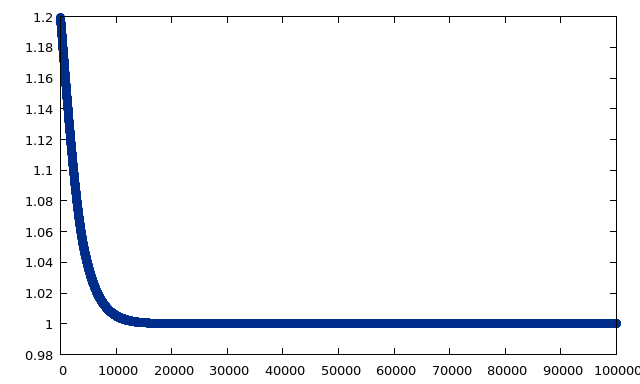

In [21]:
itorch.image('std_back')

#### Graphe pour 100k itérations, pour nn.graph

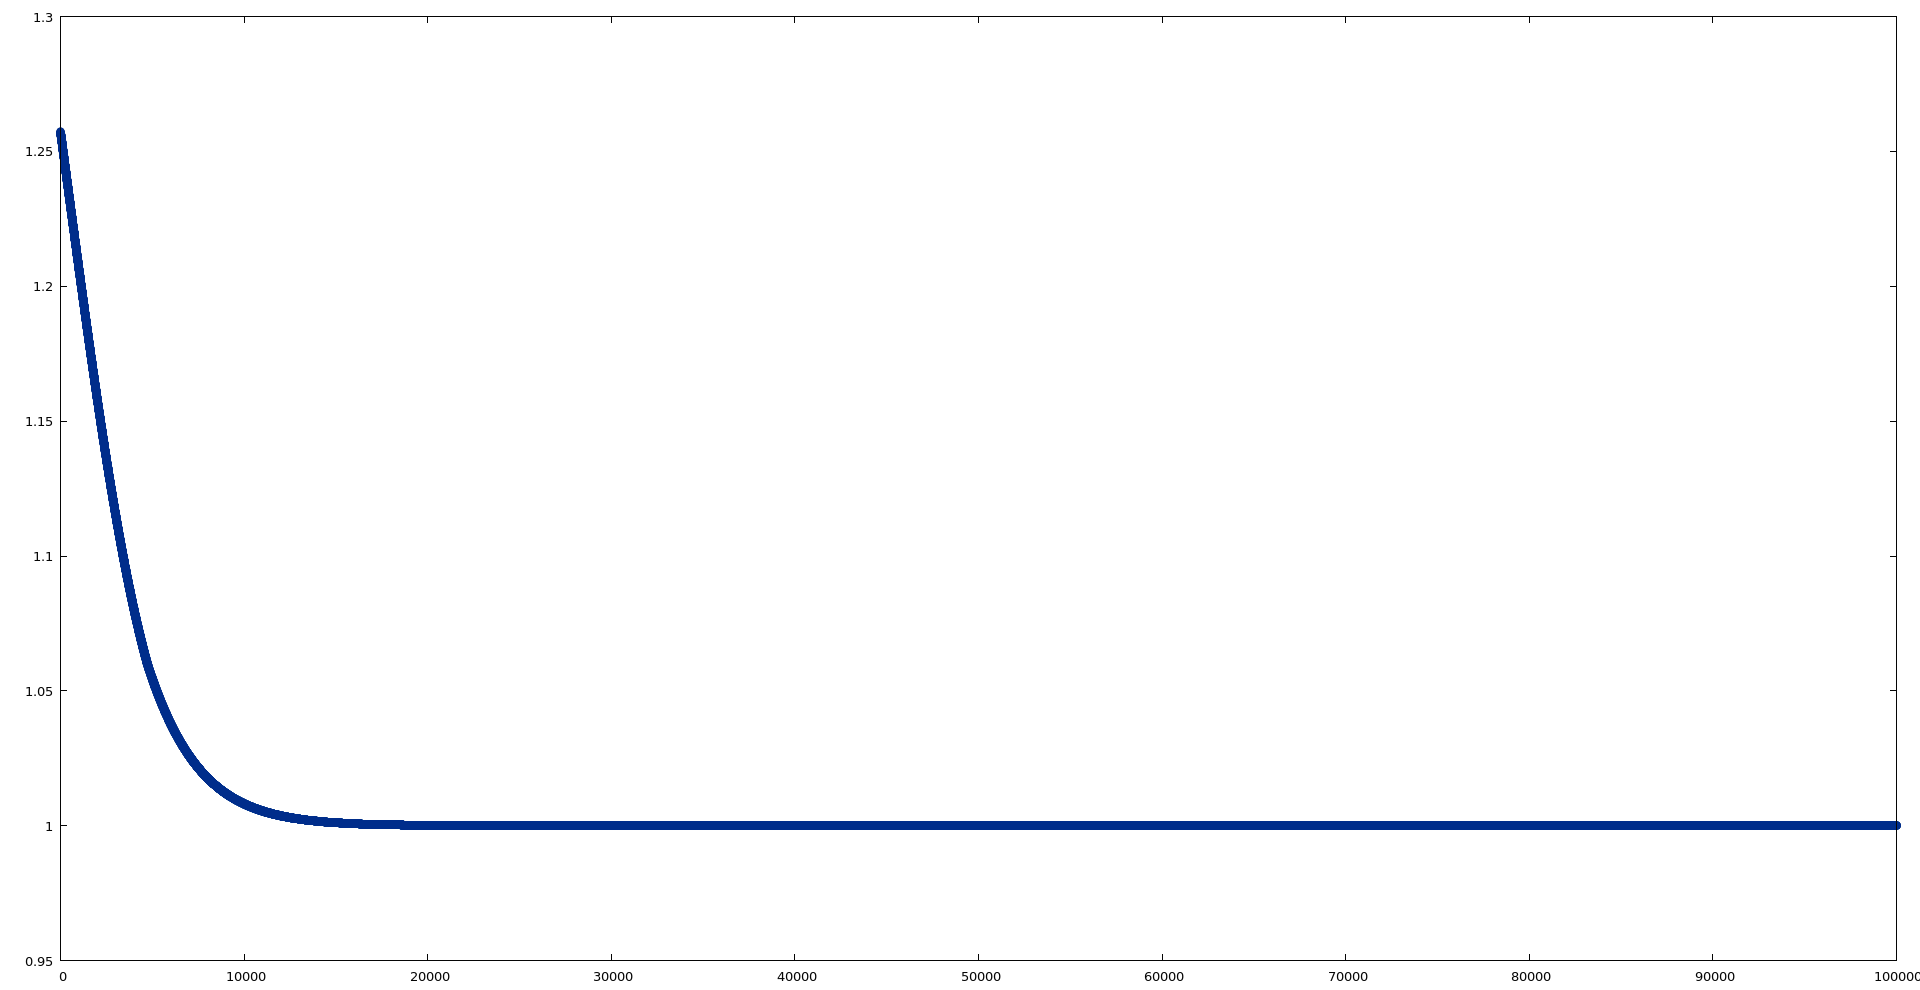

In [26]:
itorch.image('no_nn_graph_100k')